In [62]:
#导入需要的各种库
#matplotlib.pyplot: 通过该库的plt模块，可以进行数据可视化和绘制图表。
import matplotlib.pyplot as plt
#matplotlib: 这个库为pyplot提供了一些底层功能，用于配置图表的属性、样式等。
import matplotlib as mpl
#更改风格为ggplot
plt.style.use('classic')
#numpy: 这个库提供了高性能的数值计算工具，包括数组操作、线性代数运算、随机数生成等。
import numpy as np
#sklearn （即scikit-learn）: 这是一个常用的机器学习库，提供了各种机器学习算法、数据预处理工具和评估函数等。
import sklearn
#linear_model: sklearn库中的一个子模块，提供了线性回归模型和相关方法。
from sklearn import linear_model
#statistics: 这个库提供了一些统计函数，如计算标准差（stdev）和平均值（mean）。
from statistics import stdev, mean
#sklearn.feature_selection: sklearn库中的一个子模块，提供特征选择的工具和算法，包括卡方检验（chi2）等。
from sklearn.feature_selection import chi2
#subprocess：Python标准库中的一个模块，它提供了一个简单而灵活的接口来创建和控制子进程，以及与其进行交互。
#使用subprocess可以在Python程序中执行外部命令、启动其他程序，并通过管道进行输入输出的处理
import subprocess



In [63]:
## Definition of the Gaussian function
def G(x, mu, sigma):
    return np.exp(-np.power((x - mu)/sigma, 2) * (1/2))

## Definition of the Lennard-Jones function
def LJ(x,sigma,E):
    return 4*E*((sigma/x)**12.0-(sigma/x)**6.0)

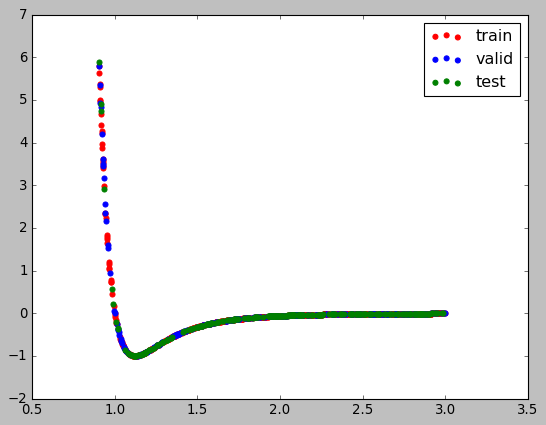

In [64]:
## Dataset Definition
# Train
N_train = 750
x_train = np.random.uniform(low=0.9, high=3.0, size=(N_train,))
y_train = LJ(x_train, 1, 1)
plt.scatter(x_train, y_train, color='red', label='train')

# Valid
N_valid = 250
x_valid = np.random.uniform(low=0.9, high=3.0, size=(N_valid,))
y_valid = LJ(x_valid, 1, 1)
plt.scatter(x_valid, y_valid, color='blue', label='valid')

# Test
N_test = 250
x_test = np.random.uniform(low=0.9, high=3.0, size=(N_test,))
y_test = LJ(x_test, 1, 1)
plt.scatter(x_test, y_test, color='green', label='test')
plt.legend()
plt.show()

In [65]:
# Parameters for feature functions

# [mu_1, ..., mu_n],
mu_min = 0.2
mu_max = 5.0
dmu = 0.2
mus=np.arange(mu_min, mu_max, dmu)


# [s_1, ..., s_m]
sigma_min = 0.2
sigma_max = 5.0
dsigma = 0.2
sigmas = np.arange(sigma_min,sigma_max,dsigma)

# Make grid of means and variances
MUs, SIGMAs = np.meshgrid(mus, sigmas)

# flatten the grid so to get a lists of D = nm gaussian parameters : [mu_1, ..., mu_{D}], [s_1, ..., s_{D}]
MUs = MUs.reshape(mus.shape[0] * sigmas.shape[0])
SIGMAs = SIGMAs.reshape(sigmas.shape[0] * sigmas.shape[0])

In [66]:
def feature_matrix(x, MUs, SIGMAs):
    """
    Ins:
    x: input data of size N,
    MUs: D 1-d gaussian means 
    SIGMAs: D 1-d gaussian standard deviation
    Outs:
    X: feature matrix of size (N, D)
    """
    D = MUs.shape[0]
    N = x.shape[0]
    
    """
    Duplicate x, D times so to get x_tiled of size (N, D)
    x_tiled = [[x1 x1 ... x1],
               [x2 x2 ... x2],
               [............],
               [xN xN ... xN]]
    """
    x_tiled = np.tile(x[:, np.newaxis], (1, D))
    
    """
    Duplicate MU, N times so to get MUs_tiled of size (N, D)
    x_tiled = [[mu1 mu2 ... muD],
               [mu1 mu2 ... muD],
               [...............],
               [mu1 mu2 ... muD]]
    """
    MUs_tiled = np.tile(MUs[np.newaxis, :], (N, 1))
    """
    Duplicate SIGMA, N times so to get SIGMAs_tiled of size (N, D)
    SIGMA_s_tiled = [[s1 s2 ... sD],
                     [s1 s2 ... sD],
                     [............],
                     [s1 s2 ... sD]]
    """
    SIGMAs_tiled = np.tile(SIGMAs[np.newaxis, :], (N, 1))
    
    """
    Matricially compute gaussian features :
    X = [[G(x1; mu1, s1), ..., G(x1; muD, sD)],
         [G(x2; mu1, s1), ..., G(x2; muD, sD)],
         [...................................],
         [G(xN; mu1, s1), ..., G(xN; muD, sD)]]
    """
    
    return G(x_tiled, MUs_tiled, SIGMAs_tiled)

X_train = feature_matrix(x_train, MUs, SIGMAs)
X_valid = feature_matrix(x_valid, MUs, SIGMAs)
X_test = feature_matrix(x_test, MUs, SIGMAs)
print(X_train.shape)
print(X_test.shape)

(750, 576)
(250, 576)


In [67]:
## OLS: Doesn't require hyperparametrization

## Ordinary Least Square
# Train
clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

# Test Prediction
y_hat_test=clf.predict(X_test)
coeff=np.copy(clf.coef_)

# Performance Evaluation
n_coeff = np.sum((coeff != 0))
mse_ols = np.mean(np.power(y_hat_test - y_test, 2))
mae_ols = np.mean(np.abs(y_hat_test - y_test))

print('mse_ols', mse_ols)
print('mae_ols', mae_ols)
print('n_coeff', n_coeff)


mse_ols 5.199650898786232e-16
mae_ols 1.5352278086980252e-08
n_coeff 576


In [68]:
## Ridge : hypertune alpha

# Validation
validation_alphas = np.power(0.1, np.arange(0, 10))
mse_ridge_valid = []
mae_ridge_valid = []
coeffs_ridge = []
norm2_ridge = []

# Train for different values of alpha and store result
for validation_alpha in validation_alphas:
    clf = sklearn.linear_model.Ridge(alpha=validation_alpha)
    clf.fit(X_train, y_train)
    y_hat_valid = clf.predict(X_valid)
    coeff_ridge = np.copy(clf.coef_)
    
    mae_ridge = np.mean(np.abs(y_hat_valid - y_valid))
    mse_ridge = np.mean(np.power(y_hat_valid - y_valid, 2))
    
    mae_ridge_valid.append(mae_ridge)
    mse_ridge_valid.append(mse_ridge)
    norm2_ridge.append(np.linalg.norm(coeff_ridge, 2))
    coeffs_ridge.append(coeff_ridge)

# Choose alpha with lowest mse.
alpha_star_ridge = validation_alphas[np.argmin(mse_ridge_valid)]

#Train
clf = sklearn.linear_model.Ridge(alpha=alpha_star_ridge)
clf.fit(X_train, y_train)

# Test Prediction
y_hat_test = clf.predict(X_test)
coeff_star_ridge = np.copy(clf.coef_)

# Performance Evaluation
mae_ridge = np.mean(np.abs(y_hat_test - y_test))
mse_ridge = np.mean(np.power(y_hat_test - y_test, 2))
norm2_ridge = np.linalg.norm(coeff_star_ridge, 2)
nonzero_ridge = np.sum(np.abs(coeff_star_ridge) > 1e-7)

print('mse: ', mse_ridge)
print('norm2: ', norm2_ridge)
print('alpha_star_ridge: ', alpha_star_ridge)
print('coeff_star_ridge: ', coeff_star_ridge[:10])
print('non_zero', nonzero_ridge)

mse:  4.077447180159896e-06
norm2:  1646.4128242395143
alpha_star_ridge:  1.0000000000000005e-09
coeff_star_ridge:  [ 1.13942669e+03 -6.63797169e+02 -4.70754035e+02 -1.49179197e+02
  1.35857821e+01  5.48946101e+01  2.60070044e+01  5.27806512e-01
  1.41158567e-01  8.23179006e+00]
non_zero 574


In [69]:
## LASSO_CD
validation_alphas = np.power(0.1, np.arange(0, 10))
mse_lcd_valid = []
mae_lcd_valid = []
coeffs_lcd = []
norm2_lcd = []
for validation_alpha in validation_alphas:
    clf = sklearn.linear_model.Lasso(alpha=validation_alpha, max_iter=1e5)
    clf.fit(X_train, y_train)
    y_hat_valid = clf.predict(X_valid)
    coeff_lcd = np.copy(clf.coef_)
    
    mae_lcd = np.mean(np.abs(y_hat_valid - y_valid))
    mse_lcd = np.mean(np.power(y_hat_valid - y_valid, 2))
    
    mae_lcd_valid.append(mae_lcd)
    mse_lcd_valid.append(mse_lcd)
    norm2_lcd.append(np.linalg.norm(coeff_lcd, 2))
    coeffs_lcd.append(coeff_lcd)
    
alpha_star_lcd = validation_alphas[np.argmin(mse_lcd_valid)]
clf = sklearn.linear_model.Lasso(alpha=alpha_star_lcd, max_iter=1e5)
clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
coeff_star_lcd = np.copy(clf.coef_)
mae_lcd = np.mean(np.abs(y_hat_test - y_test))
mse_lcd = np.mean(np.power(y_hat_test - y_test, 2))
norm2_lcd = np.linalg.norm(coeff_star_lcd, 2)
nonzero_lcd = np.sum(np.abs(coeff_star_lcd) > 1e-7)

print('alpha_star: ', alpha_star_lcd)
print('mse: ', mse_lcd)
print('mae: ', mae_lcd)
print('norm2_lcd: ', norm2_lcd)
print('nonzero_lcd: ', nonzero_lcd)

InvalidParameterError: The 'max_iter' parameter of Lasso must be an int in the range [1, inf) or None. Got 100000.0 instead.

In [ ]:
## LASSO_LARS
validation_alphas = np.power(0.1, np.arange(0, 10))
mse_lla_valid = []
mae_lla_valid = []
coeffs_lla = []
norm2_lla = []
for validation_alpha in validation_alphas:
    clf = sklearn.linear_model.LassoLars(alpha=validation_alpha)
    clf.fit(X_train, y_train)
    y_hat_valid = clf.predict(X_valid)
    coeff_lla = np.copy(clf.coef_)
    
    mae_lla = np.mean(np.abs(y_hat_valid - y_valid))
    mse_lla = np.mean(np.power(y_hat_valid - y_valid, 2))
    
    mae_lla_valid.append(mae_lla)
    mse_lla_valid.append(mse_lla)
    norm2_lla.append(np.linalg.norm(coeff_lla, 2))
    coeffs_lla.append(coeff_lla)
    
alpha_star_lla = validation_alphas[np.argmin(mse_lla_valid)]
clf = sklearn.linear_model.LassoLars(alpha=alpha_star_lla)
clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
coeff_star_lla = np.copy(clf.coef_)
mae_lla = np.mean(np.abs(y_hat_test - y_test))
mse_lla = np.mean(np.power(y_hat_test - y_test, 2))
norm2_lla = np.linalg.norm(coeff_star_lla, 2)
nonzero_lla = np.sum(np.abs(coeff_star_lla) > 1e-7)

print('alpha_star_lla', alpha_star_lla)
print('mse: ', mse_lla)
print('mae: ', mae_lla)
print('norm2_lcd: ', norm2_lla)
print('nonzero_lcd: ', nonzero_lla)

alpha_star_lla 1.0000000000000005e-09
mse:  4.107811397471394e-06
mae:  0.0007522151976336502
norm2_lcd:  7780431.034704701
nonzero_lcd:  13


(750,)
(750,)


/home/tallec/miniconda3/envs/neovim3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.533331477484, tolerance: 0.04160724406329821
  positive)


(0.75, 3.0, -1.5, 2.0)

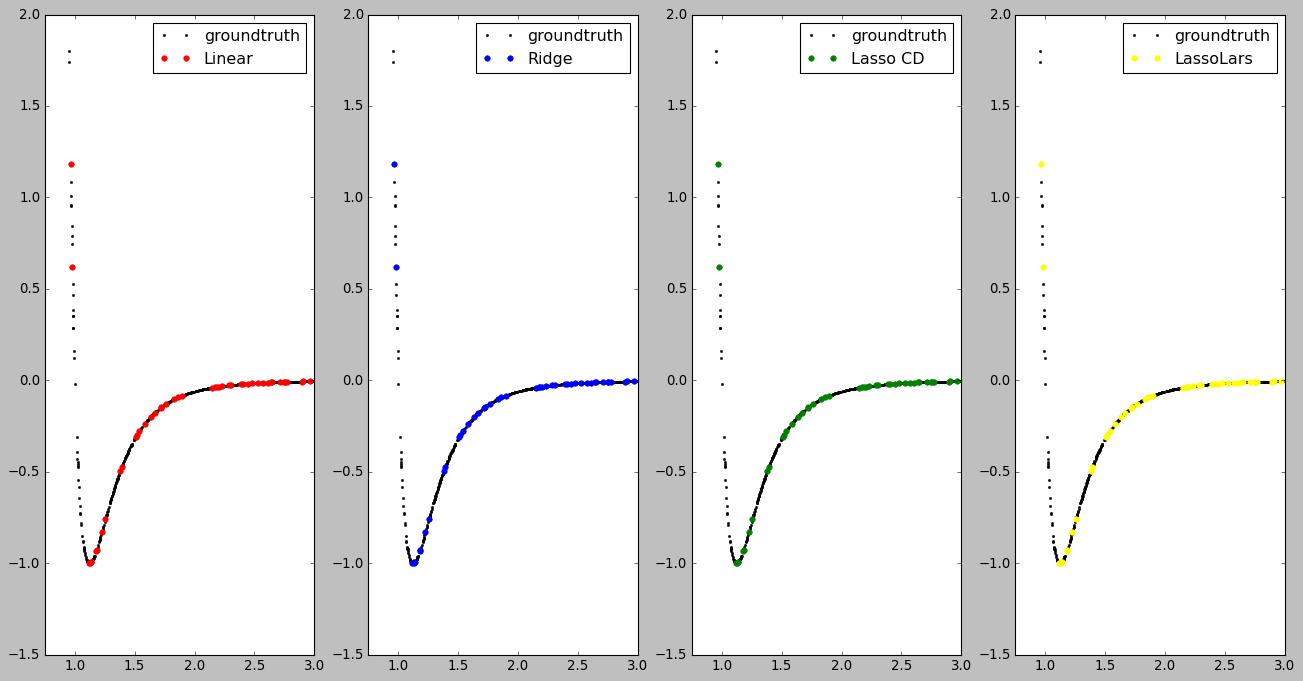

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 10))
print(x_train.shape)
print(y_train.shape)

for i in range(len(ax)):
    ax[i].plot(x_train,y_train, '.', label='groundtruth', markersize=4, color='black')

## Ordinary Least Square
clf =linear_model.LinearRegression()
clf.fit(X_train, y_train)
y_hat_test=clf.predict(X_test)
coeff=np.copy(clf.coef_)
test=coeff!=0
Error0=np.mean(abs(y_hat_test-y_test)) 
N0=np.sum(test)
Scale0=np.mean(abs(coeff))
ax[0].plot(x_test,y_test,".",label="Linear",markevery=5,markersize=10, color='red')
ax[0].legend()
ax[0].axis([0.75,3,-1.5,2])

## Ridge
clf =linear_model.Ridge(alpha=alpha_star_ridge)
clf.fit(X_train, y_train)
y_hat_test=clf.predict(X_test)
coeff=np.copy(clf.coef_)
test=coeff!=0
Error1=np.mean(abs(y_hat_test-y_test)) 
N1=np.sum(test)
Scale1=np.mean(abs(coeff))
ax[1].plot(x_test,y_test,".",label="Ridge",markevery=5,markersize=10, color='blue')
ax[1].legend()
ax[1].axis([0.75,3,-1.5,2])

## LassoCoordinateDescent
clf =linear_model.Lasso(alpha=alpha_star_lcd)
clf.fit(X_train, y_train)
y_hat_test=clf.predict(X_test)
coeff=np.copy(clf.coef_)
test=coeff!=0
Error2=np.mean(abs(y_hat_test-y_test)) 
N2=np.sum(test)
Scale2=np.mean(abs(coeff))
ax[2].plot(x_test,y_test,".",label="Lasso CD",markevery=5,markersize=10, color='green')
ax[2].legend()
ax[2].axis([0.75,3,-1.5,2])

## LassoLars
clf =linear_model.LassoLars(alpha=alpha_star_lla)
clf.fit(X_train, y_train)
y_hat_test=clf.predict(X_test)
coeff=np.copy(clf.coef_)
test=coeff!=0
Error3=np.mean(abs(y_hat_test-y_test)) 
N3=np.sum(test)
Scale3=np.mean(abs(coeff))
ax[3].plot(x_test,y_test,".",label="LassoLars",markevery=5,markersize=10, color='yellow')
ax[3].legend()
ax[3].axis([0.75,3,-1.5,2])

## More plot settings and figure saving
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels,loc="upper center",bbox_to_anchor=(0.5, 1.55),ncol=2,fontsize = 'x-small')
plt.axis()





In [ ]:
print ("########################")

print ("Method Error N_coeff ")
print ("Linear", Error0, N0,Scale0)
print ("Ridge", Error1, N1,Scale1) 
print ("Lasso", Error2, N2,Scale2)
print ("LassoLars", Error3, N3,Scale3)


########################
Method Error N_coeff 
Linear 0.32593230200399687 576 57660446462.9137
Ridge 0.2973296013394378 576 133.05418817174922
Lasso 0.29295104491668517 287 1.143277187502819
LassoLars 0.29599580092046723 17 3399245513615194.0
